In [1]:
import numpy as np
import matplotlib.pyplot as plt

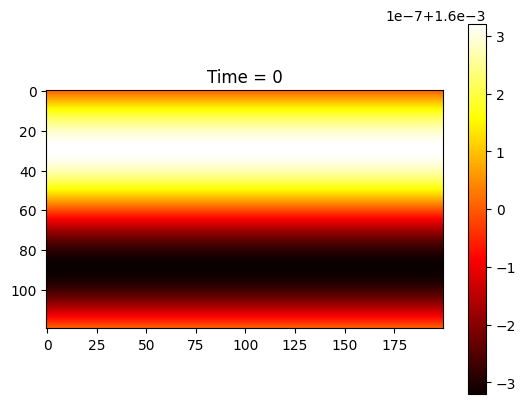

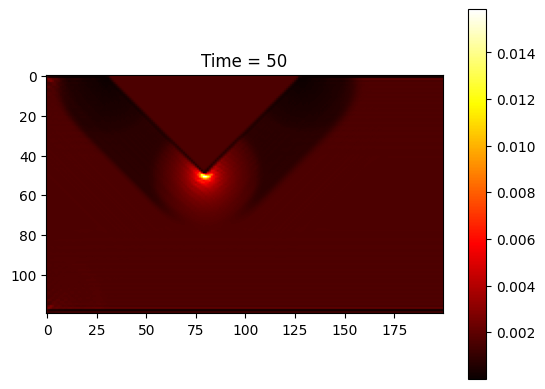

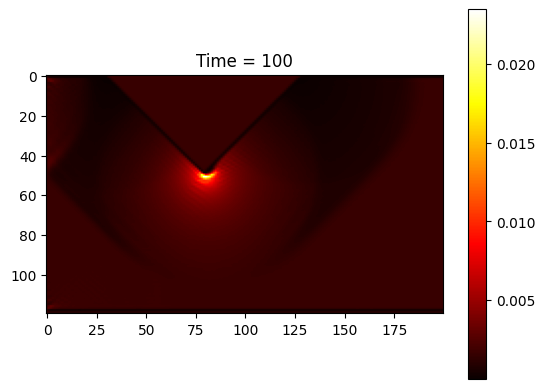

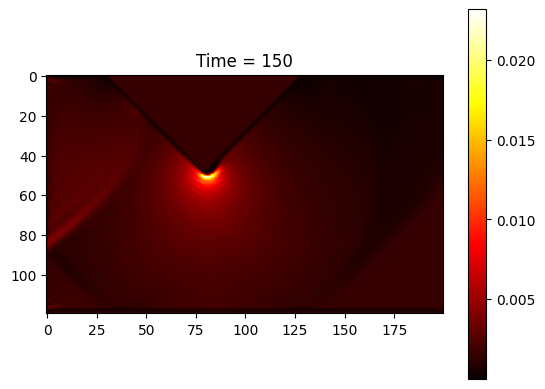

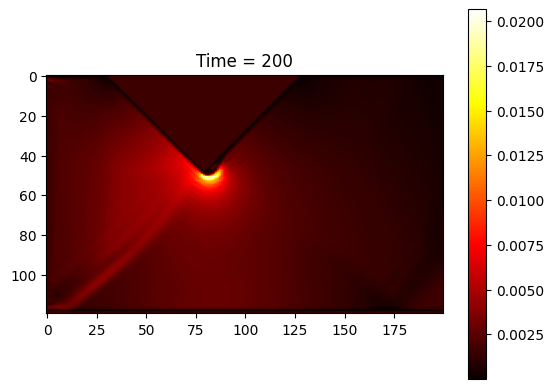

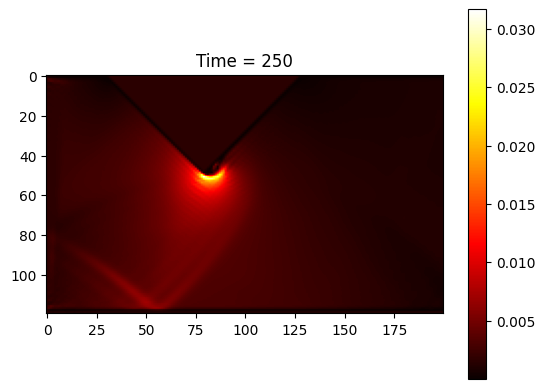

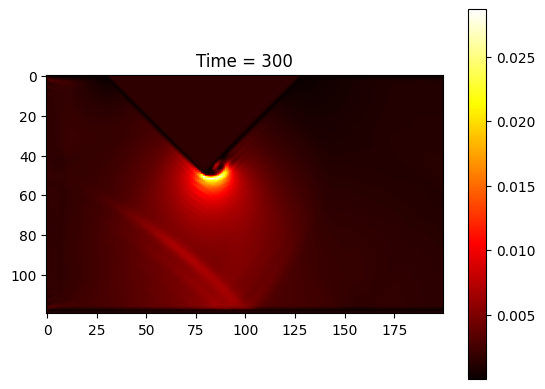

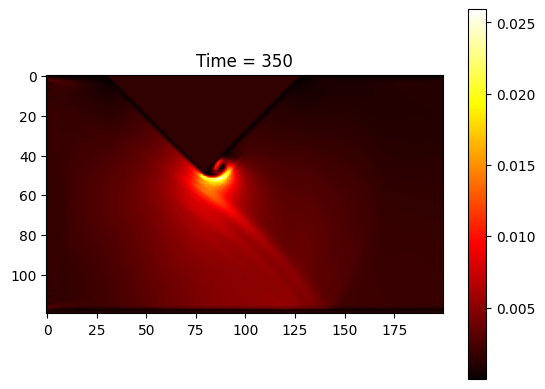

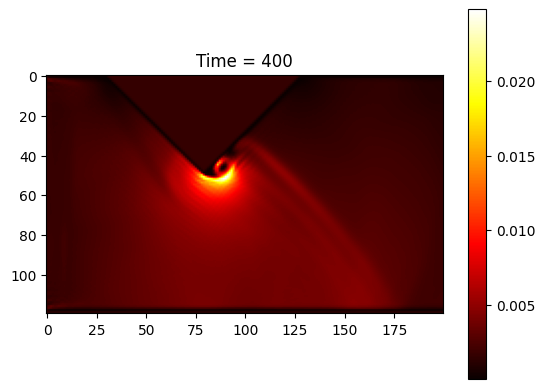

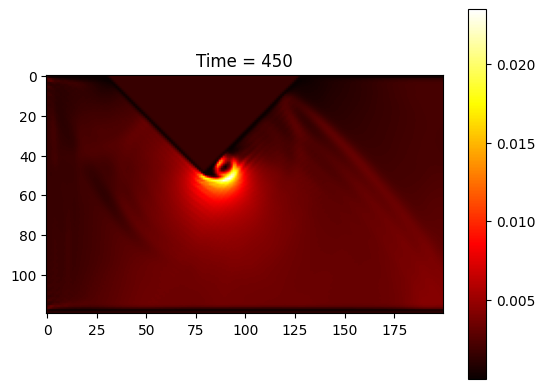

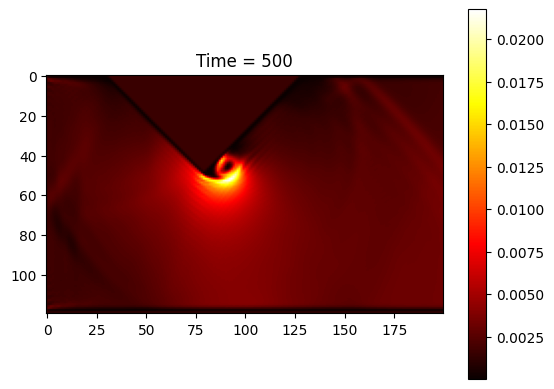

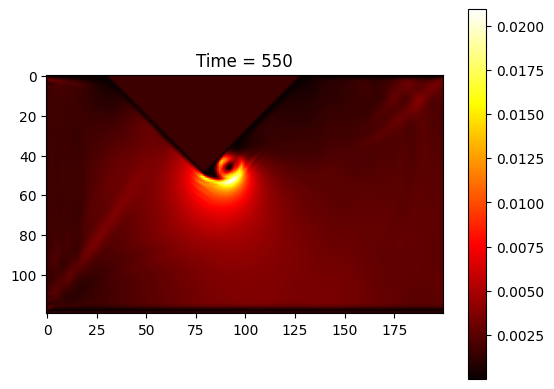

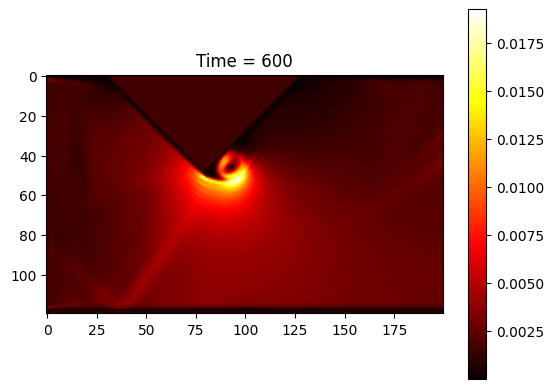

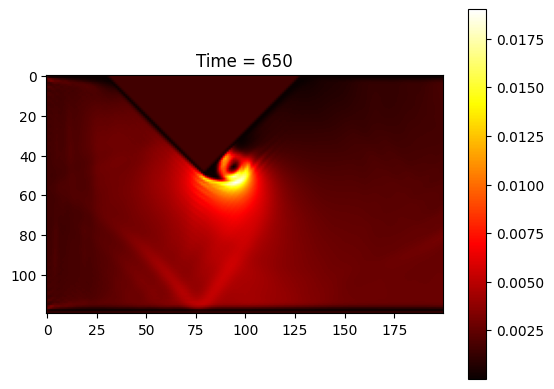

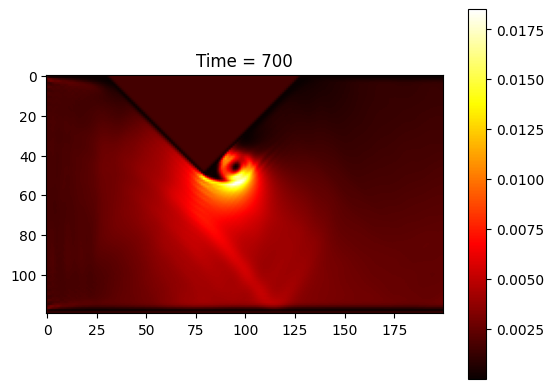

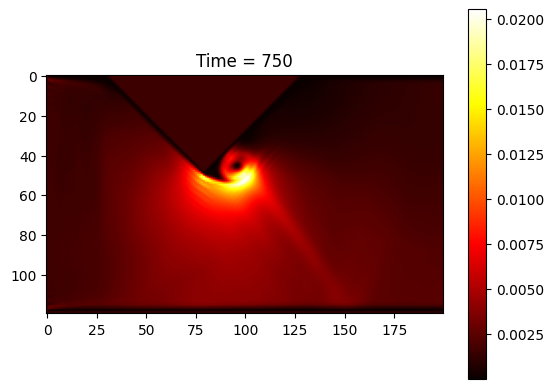

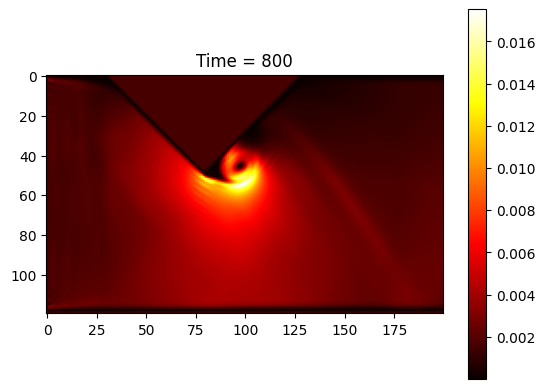

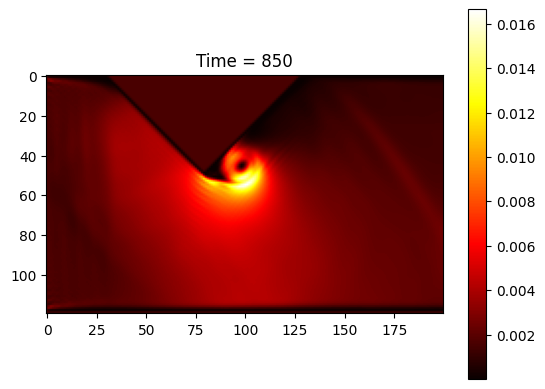

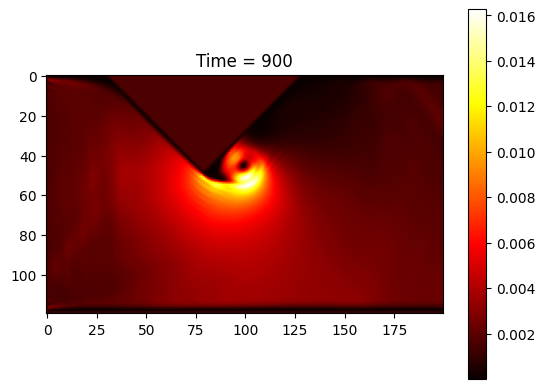

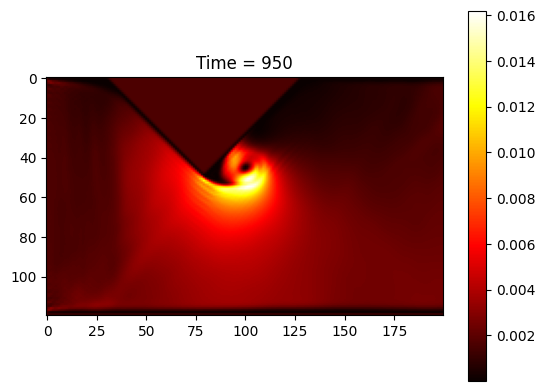

In [25]:
# constant & stuff

W = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
e = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1], [1,1], [-1,1], [-1,-1], [1,-1]])

N_c = 200   # number of columns 520
N_r = 120   # number of rows 180
wedge_start = 30
wedge_height = 50
u_in = 0.04
eps = 0.0001
Re = 1000
v_lb = u_in*(N_r/2)/Re
tau = 3*v_lb + 1/2

# equilibrium flow function - those are population of particles travelling in each direction

def flow_eq(velo, dens):
    return np.array([W[i]*dens*(1 + 3*(velo[0]*e[i][0] + velo[1]*e[i][1]) + 9/2*(velo[0]*e[i][0] + velo[1]*e[i][1])**2 - 3/2*(velo[0]**2 + velo[1]**2)) for i in range(9)])

def energy(flow, density):
    v = np.zeros([N_r, N_c, 2])

    for i in range(9):
        v[:, :, 0] = v[:, :, 0] + flow[:, :, i] * e[i][0] / density
        v[:, :, 1] = v[:, :, 1] + flow[:, :, i] * e[i][1] / density

    plot = v[:, :, 0]*v[:, :, 0] + v[:, :, 1]*v[:, :, 1]
    return np.mean(plot)

def mass(flow):
    d = np.zeros([N_r, N_c])
    for i in range(9):
        d = d + flow[:, :, i]
    return np.sum(d)

# ok, so we declare array of 2D velocities in every point of board
# that velocity is mean macroscopic velocity in that point

velocities = np.empty([N_r, N_c, 2])
velocities[:, :, 1] = 0
for r in range(N_r):
    velocities[r, :, 0] = u_in*(1 + eps*(np.sin(2*np.pi*r/(N_r-1))))

u0 = velocities[:, 0, 0].copy() # first column of velocities in X directions
u_eq = velocities[:, 0, :].copy()

# now, we declare array of local 1D densities in every point of board
# macroscopic densities

density = np.ones([N_r, N_c])

# very cool, now declare array of 9D densities of flow 
# each flow is microscopic fraction of particles travelling in i direction

flow = np.empty([N_r, N_c, 9])
for c in range(N_c):
    for r in range(N_r):
        flow[r, c, :] = flow_eq(velo = velocities[r, c, :], dens = density[r, c])

flow2 = flow.copy()

# one time step

def stream(flow_board):
    new_board = np.zeros(flow_board.shape)
    for i in range(9):
        new_board[:, :, i] = np.roll(np.roll(flow_board[:, :, i], e[i][0], axis = 1), e[i][1], axis = 0)

    return new_board

# create board of reversed flows

def reverse(array):
    new_array = []
    for i in [0, 3, 4, 1, 2, 7, 8, 5, 6]:
        new_array.append(array[i])
    return np.array(new_array)

rev_flow = reverse(flow)

# wedge coordinates

wedge = []

for c in range(wedge_height):
    for r in range(c+1):
        wedge.append([r, c + wedge_start])

for c in range(wedge_height):
    for r in range(wedge_height - c):
        wedge.append([r, c + wedge_start + wedge_height - 1])

# TIME LOOP

time = 1000

# board is already initialized

for t in range(time):

    # in first step inlet is just fine, but later it will be destroyed by rolls

    # firstly let's calculate current density of flow in inlet

    density[:, 0] = (2*(flow[:, 0, 3] + flow[:, 0, 6] + flow[:, 0, 7]) + flow[:, 0, 0] + flow[:, 0, 2] + flow[:, 0, 4]) / (1 - u0)

    # now inlet flow

    for r in range(N_r):
        flow[r, 0, 1] = flow_eq(u_eq[r,:], density[r, 0])[1]
        flow[r, 0, 5] = flow_eq(u_eq[r,:], density[r, 0])[5]
        flow[r, 0, 8] = flow_eq(u_eq[r,:], density[r, 0])[8]

    # cool, cool. Now inlet flow on outlet
    
    for r in range(N_r):
        flow[r, N_c - 1, 3] = flow[r, N_c - 2, 3]
        flow[r, N_c - 1, 6] = flow[r, N_c - 2, 6]
        flow[r, N_c - 1, 7] = flow[r, N_c - 2, 7]
    
    # recalculate everywhere the density

    density = np.zeros([N_r, N_c])
    for i in range(9):
        density = density + flow[:, :, i]

    # and calculate velocities

    velocities[:, :, :] = 0

    for i in range(9):
        velocities[:, :, 0] += flow[:, :, i] * e[i][0] / density[:, :]
        velocities[:, :, 1] += flow[:, :, i] * e[i][1] / density[:, :]

    # calculate equilibrium flow

    for c in range(N_c):
        for r in range(N_r):
            flow2[r, c, :] = flow_eq(velocities[r, c, :], density[r, c])

    # calculate flow with collisions

    flow_col = flow.copy()

    flow_col = flow - (flow-flow2)/tau

    # borders
    
    for c in range(N_c):
        flow_col[0, c, :] = reverse(flow[0, c, :])
        flow_col[N_r-1, c, :] = reverse(flow[N_r-1, c, :])

    for [r, c] in wedge:
        flow_col[r, c, :] = reverse(flow[r, c, :])

    # TIME STEP

    flow = stream(flow_col)

    # art time

    if t % 50 == 0:
        plot = velocities[:, :, 0]*velocities[:, :, 0] + velocities[:, :, 1]*velocities[:, :, 1]
        plt.imshow(plot, cmap = "hot", interpolation = None)
        plt.title("Time = {}".format(t))
        plt.colorbar()
        plt.show()
        #print("Time = {}".format(t))
        '''
        print("Energia = " + str(energy(flow[:, :, :], density[:, :])))
        print("Masa = "+ str(mass(flow[:, :, :])))
        print("Minimalna gęstość = " + str(np.min(density[:, :])))
        '''